In [48]:
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp # for reference

import autograd.numpy as np
from neuralsolver import NNSolver

In [49]:
"""
Reference:
Lagaris, Isaac E., Aristidis Likas, and Dimitrios I. Fotiadis.
"Artificial neural networks for solving ordinary and partial
differential equations." IEEE Transactions on Neural Networks
 9.5 (1998): 987-1000.
"""

# autograd core
import autograd.numpy as np
from autograd import grad
from autograd import elementwise_grad as egrad

# autograd utils
import autograd.numpy.random as npr
from autograd.misc.flatten import flatten

# scipy optimizer
from scipy.optimize import minimize

#plot animation
from matplotlib import animation, rc
from IPython.display import HTML

# A global counter for printing scipy training progress
# https://stackoverflow.com/questions/16739065/how-to-display-progress-of-scipy-optimize-function
# TODO: Can we improve this dirty hack?
count = 0


def init_weights(n_in=1, n_hidden=10, n2_hidden = 10, n_out=1):
    '''
    Initialize NN weights
    '''
    # TODO: more layers?
    W1 = npr.randn(n_in, n_hidden)
    b1 = np.zeros(n_hidden)
    W2 = npr.randn(n_hidden, n2_hidden)
    b2 = np.zeros(n2_hidden)
    W3 = npr.randn(n2_hidden, n_out)
    b2 = np.zeros(n_out)
    
    
    params = [W1, b1, W2, b2, W3, b2]
    return params


def predict(params, t, y0, act=np.tanh):
    '''
    Make NN prediction
    '''
    W1, b1, W2, b2, W3, b3 = params

    a = act(np.dot(t, W1) + b1)
    b = act(np.dot(a, W2) + b2)
    out = np.dot(b, W3) + b3  # standard NN output

    # TODO: start with t0 instead of 0
    y = y0 + t*out  # apply Lagaris et al. (1998)

    return y


predict_dt = egrad(predict, argnum=1)  # element-wise grad w.r.t t


class NNSolver(object):
    def __init__(self, f, t, y0_list, n_hidden=10, n2_hidden=10):
        '''
        Neural Network Solver Class

        Parameters
        ----------
        f : callable
            Right-hand side of the ODE system dy/dt = f(t, y).
            Similar to the input for scipy.integrate.solve_ivp()

            Important notes:
            - Must use autograd's numpy inside f (import autograd.numpy as np)
            - For a single ODE, should return a list of one element.

        t : column vector, i.e. numpy array of shape (n, 1)
            Training points

        y0_list : a list of floating point numbers
            Initial condition.
            For a single ODE, should be a list of one element.

        n_hidden : integer, optional
            Number of hidden units of the NN
        '''

        Nvar = len(y0_list)
        assert len(f(t[0], y0_list)) == Nvar, \
            'f and y0_list should have same size'

        assert t.shape == (t.size, 1), 't must be a column vector'

        self.Nvar = Nvar
        self.f = f
        self.t = t
        self.y0_list = y0_list
        self.n_hidden = n_hidden
        self.n2_hidden = n2_hidden

        self.reset_weights()

    def __str__(self):
        return ('Neural ODE Solver \n'
                'Number of equations:       {} \n'
                'Initial condition y0:      {} \n'
                'Numnber of hidden units:   {}, {} \n'
                'Number of training points: {} '
                .format(self.Nvar, self.y0_list, self.n_hidden, self.n2_hidden, self.t.size)
                )

    def __repr__(self):
        return self.__str__()

    def reset_weights(self):
        '''reinitialize NN weights (randomly)'''
        self.params_list = [init_weights(n_hidden=self.n_hidden, n2_hidden=self.n2_hidden)
                            for _ in range(self.Nvar)]

        flattened_params, unflat_func = flatten(self.params_list)
        self.flattened_params = flattened_params
        self.unflat_func = unflat_func

    def loss_func(self, params_list):
        '''Compute loss function'''
        # params_list should be an explicit input, not from self

        # some shortcut
        y0_list = self.y0_list
        t = self.t
        f = self.f

        y_pred_list = []
        dydt_pred_list = []
        for params, y0 in zip(params_list, y0_list):
            y_pred = predict(params, t, y0)
            dydt_pred = predict_dt(params, t, y0)

            y_pred_list.append(y_pred)
            dydt_pred_list.append(dydt_pred)

        f_pred_list = f(t, y_pred_list)

        loss_total = 0.0
        for f_pred, dydt_pred in zip(f_pred_list, dydt_pred_list):
            loss = np.mean((dydt_pred-f_pred)**2)
            loss_total += loss

        return loss_total

    def loss_wrap(self, flattened_params):
        '''Loss function that takes flattened parameters, for scipy optimizer
        '''
        # flattened_params should be an explicit input, not from self
        params_list = self.unflat_func(flattened_params)

        return self.loss_func(params_list)

    def train(self, method='BFGS', maxiter=2000, iprint=200):
        '''
        Train the neural net

        Parameters
        ----------
        method : string, optional
            Optimization method for scipy.optimize.minimize()
            'BFGS' should be the most robust one

        maxiter : integer, optional
            Maximum number of iterations

        maxiter : integer, optional
            Print loss per iprint step
        '''
        self.x = [] # updates of x during training



        global count
        count = 0  # reset counter for next training

        def print_loss(x):
            global count
            if count % iprint == 0:
                print("iteration:", count, "loss: ", self.loss_wrap(x))
            count += 1

            # add new training updates to x
            self.x.append(self.unflat_func(x))

        opt = minimize(self.loss_wrap, x0=self.flattened_params,
                       jac=grad(self.loss_wrap), method=method,
                       callback=print_loss,
                       options={'disp': True, 'maxiter': maxiter})

        # update parameters
        self.flattened_params = opt.x
        self.params_list = self.unflat_func(opt.x)
        

    def predict(self, t=None, params_list=None):
        '''
        Make new predicts

        Parameters
        ----------
        t : column vector, i.e. numpy array of shape (n, 1), optional
            use training points by default

        '''
        if t is None:
            t = self.t

        if params_list is None:
            y_pred_list = []
            dydt_pred_list = []
            for params, y0 in zip(self.params_list, self.y0_list):
                y_pred = predict(params, t, y0)
                dydt_pred = predict_dt(params, t, y0)

                y_pred_list.append(y_pred.squeeze())
                dydt_pred_list.append(dydt_pred.squeeze())

            return y_pred_list, dydt_pred_list
        
        else:
            y_pred_list = []
            for params, y0 in zip(params_list, self.y0_list):
                y_pred = predict(params, t, y0)

                y_pred_list.append(y_pred.squeeze())

            return y_pred_list
    def result(self,t = None, anim = False, interval = 50):
        '''
        Note: need to brew install ffmpeg
        '''
        if t is None:
            t = self.t
            
        
        if animation:
            
            #training animation
            y_train = np.array([nn.predict(t = t.reshape(-1,1), params_list=x)[0] for x in nn.x])
            # First set up the figure, the axis, and the plot element we want to animate
            fig, ax = plt.subplots()

            ax.set_xlim((t[0], t[-1]))
            ax.set_ylim((min(y_train[-1]), max(y_train[-1])))

            line, = ax.plot([], [], lw=2)
            scat = ax.scatter([], [])
            
            # initialization function: plot the background of each frame
            def init():
                line.set_data([], [])
                scat.set_offsets(np.hstack(([], [])))
                return (line,scat)
            # animation function. This is called sequentially
            def animate(i):
                line.set_data(t, y_train[i,:])
                scat.set_offsets(np.c_[t, y_train[i,:]])
                ax.set_title("Accuracy = 0")
                return (line, scat)
            
            # call the animator. blit=True means only re-draw the parts that have changed.
            anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=y_train.shape[0], interval=interval, blit=True)
            
            return anim

**Due to internal code design, single ODE should also be written in a ODE system form.**

In [50]:
def f(t, y):
    '''
        dy/dt = f(t, y)
        This is f() function on the right
    '''    
    return [-y[0] + np.sin(t)] # should be a list

t = np.linspace(0, 6, 20).reshape(-1,1)
y0_list = [1] # should be a list

In [51]:
sol = solve_ivp(f, [t.min(), t.max()], y0_list, method='Radau', rtol=1e-5)

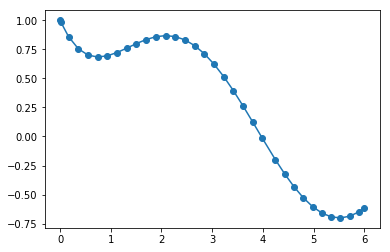

In [52]:
plt.plot(sol.t, sol.y[0], marker='o')

In [53]:
nn = NNSolver(f, t, y0_list)
nn

Neural ODE Solver 
Number of equations:       1 
Initial condition y0:      [1] 
Numnber of hidden units:   10, 10 
Number of training points: 20 

In [54]:
nn.reset_weights()
%time nn.train()

iteration: 0 loss:  0.297396575525
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 180
         Function evaluations: 202
         Gradient evaluations: 202
CPU times: user 1.17 s, sys: 28.6 ms, total: 1.2 s
Wall time: 1.19 s


In [55]:
nn.loss_func(nn.params_list)

3.8414403309149835e-08

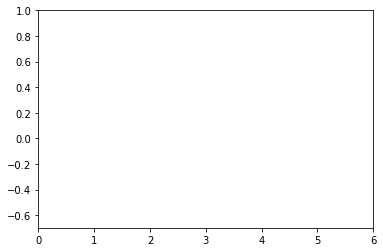

In [56]:
anim = nn.result(t = np.linspace(0,6,30), anim=True)

In [57]:
HTML(anim.to_html5_video())

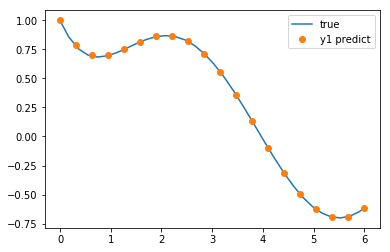

In [47]:
y_pred_list, _ = nn.predict()
plt.plot(sol.t, sol.y[0], label='true')
plt.plot(t, y_pred_list[0], 'o', label='y1 predict')
plt.legend()

---

## Visualizing difference

In [36]:
tru.y.shape

(1, 20)

In [33]:
tru = solve_ivp(f, [t.min(), t.max()],t_eval= np.ravel(t), y0 = y0_list, method='Radau', rtol=1e-5)

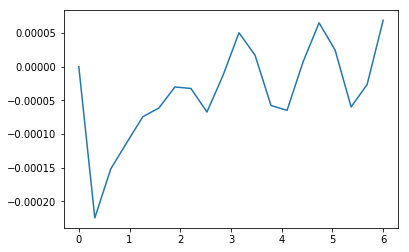

In [37]:
plt.plot(t,tru.y[0] - y_pred_list[0])